<a href="https://colab.research.google.com/github/Art9521/Art9521/blob/main/Game-WIN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.despine()

import warnings
warnings.filterwarnings("ignore")

from subprocess import check_output
%matplotlib inline

import seaborn as sns
import sys

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"

import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'keras.layers.core'

<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv('gdrive/My Drive/train_V2.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


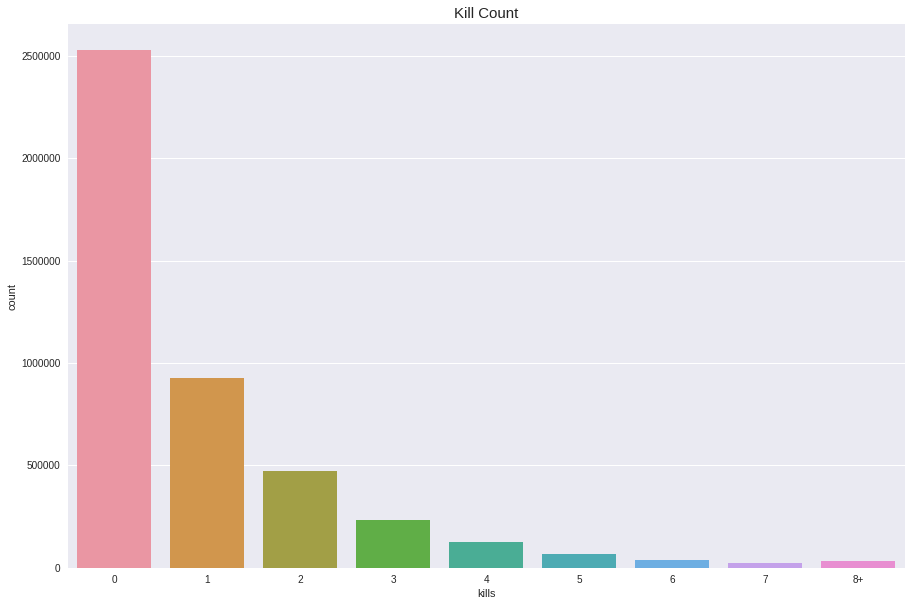

In [ ]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

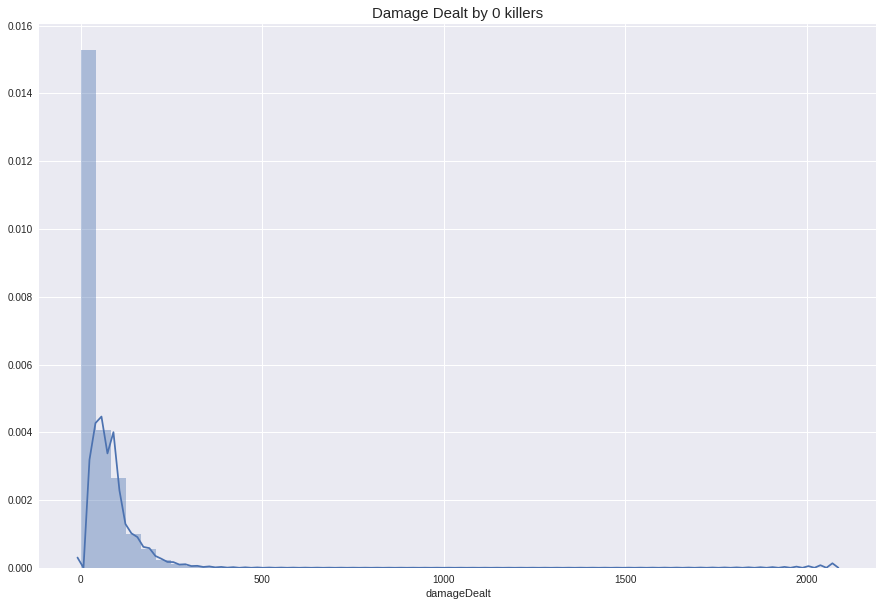

In [ ]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [ ]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 players (0.0000%) have won without a single kill!
4770 players (0.0000%) have won without dealing damage!


In [ ]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="r")
plt.show()

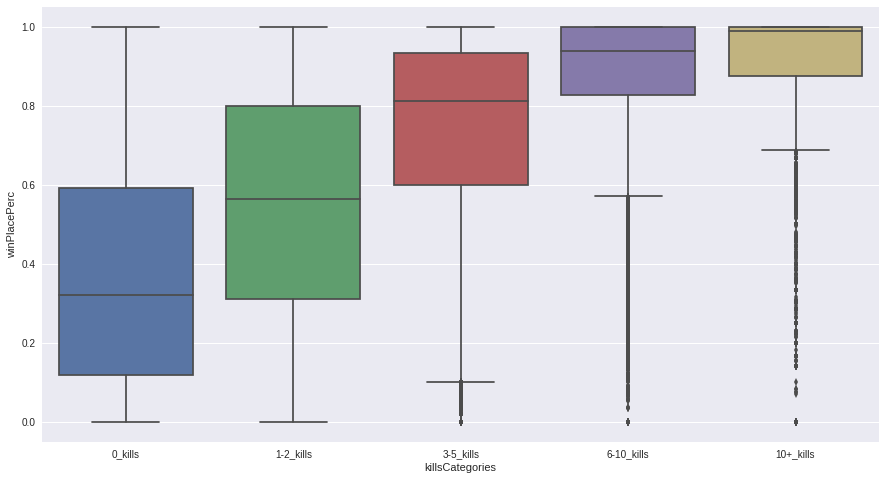

In [ ]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

In [ ]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

The average person walks for 1154.2m, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25780.0m.


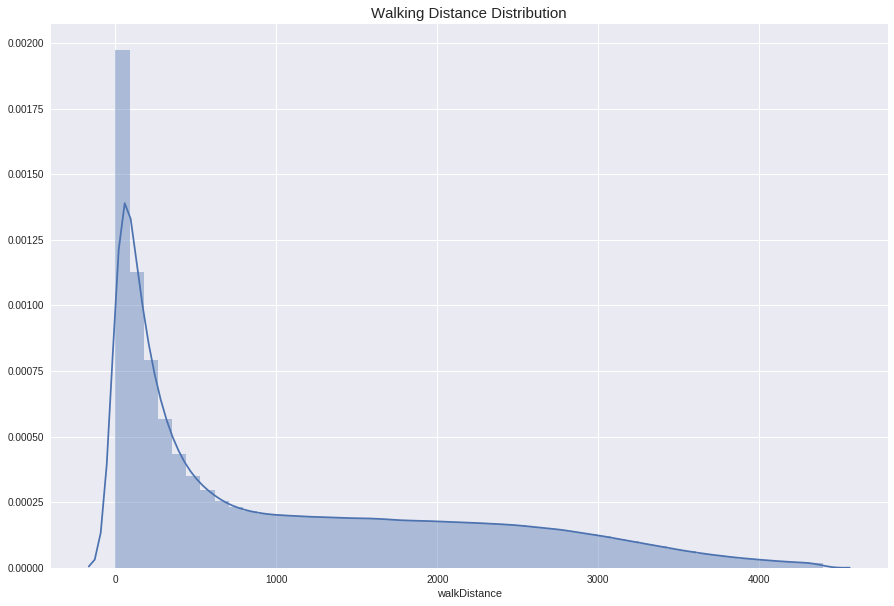

In [ ]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [ ]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

99603 players (2.0000%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).


In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="lime")
plt.show()

In [ ]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the formula 1 champion drived for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the formula 1 champion drived for 40710.0m.


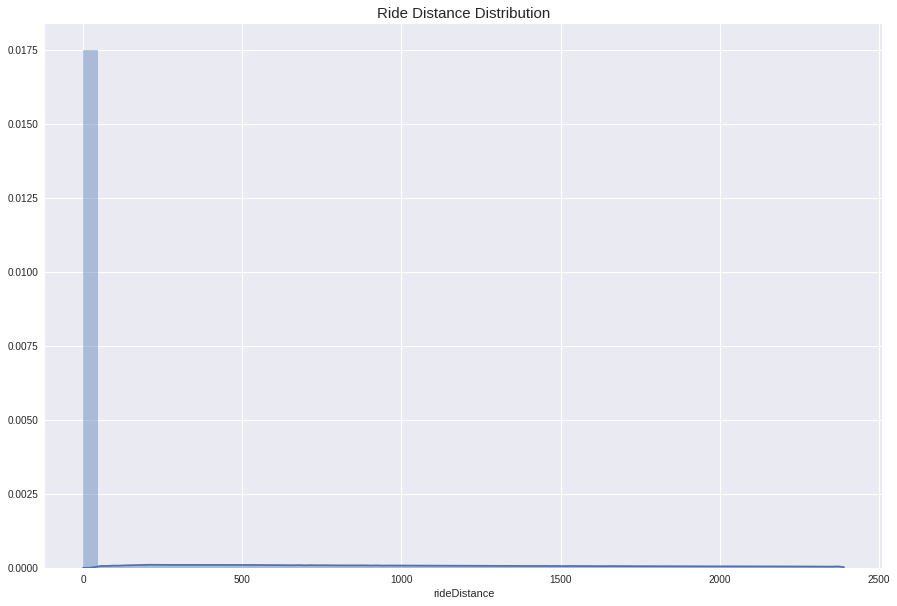

In [ ]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [ ]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.0000%) drived for 0 meters. This means that they don't have a driving licence yet.


In [ ]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color="y")
plt.show()

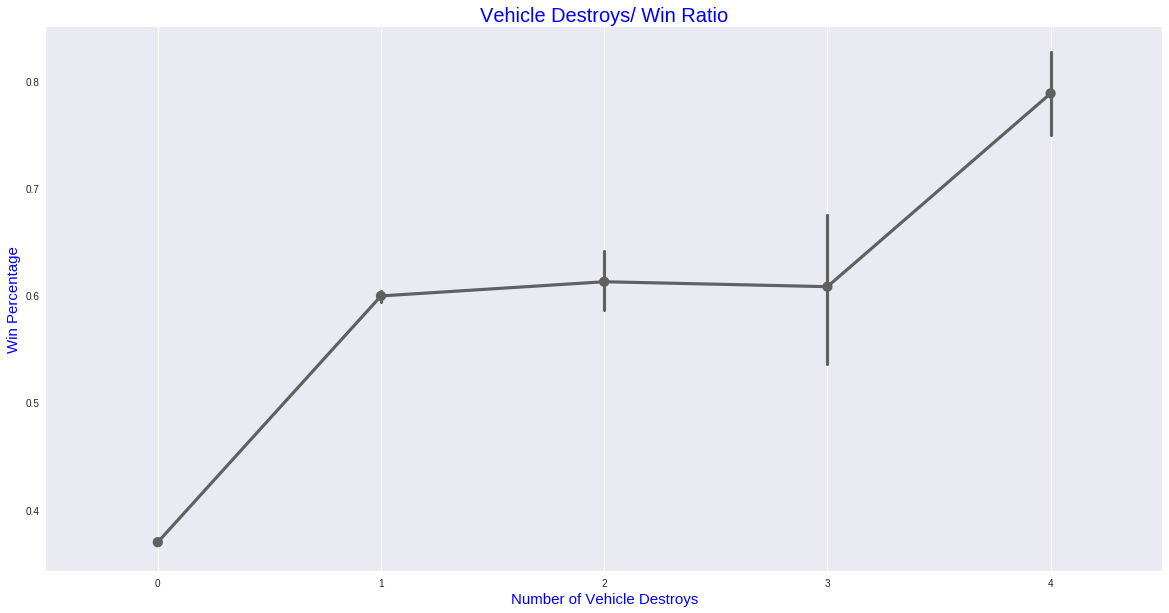

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

In [ ]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

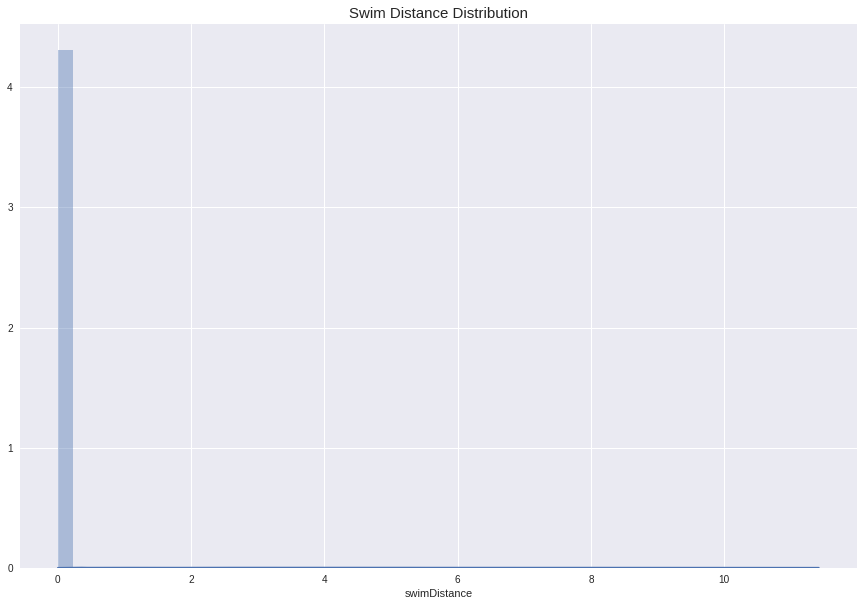

In [ ]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

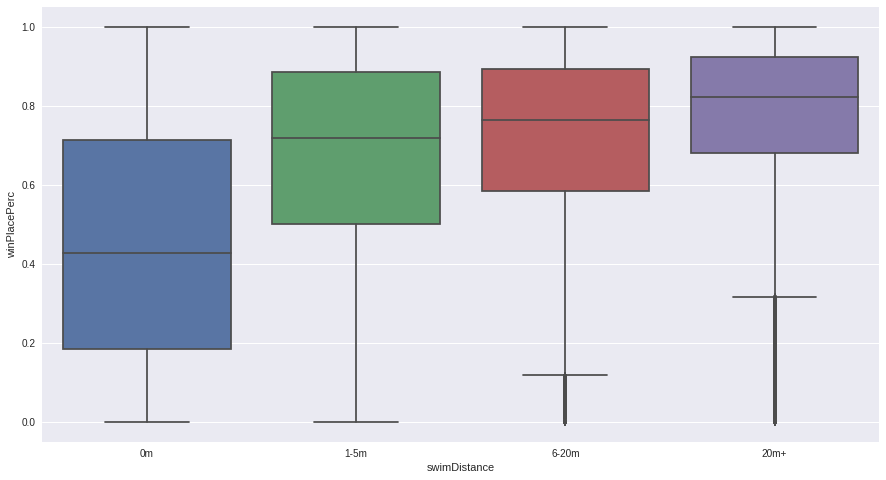

In [ ]:
swim = train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

In [ ]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


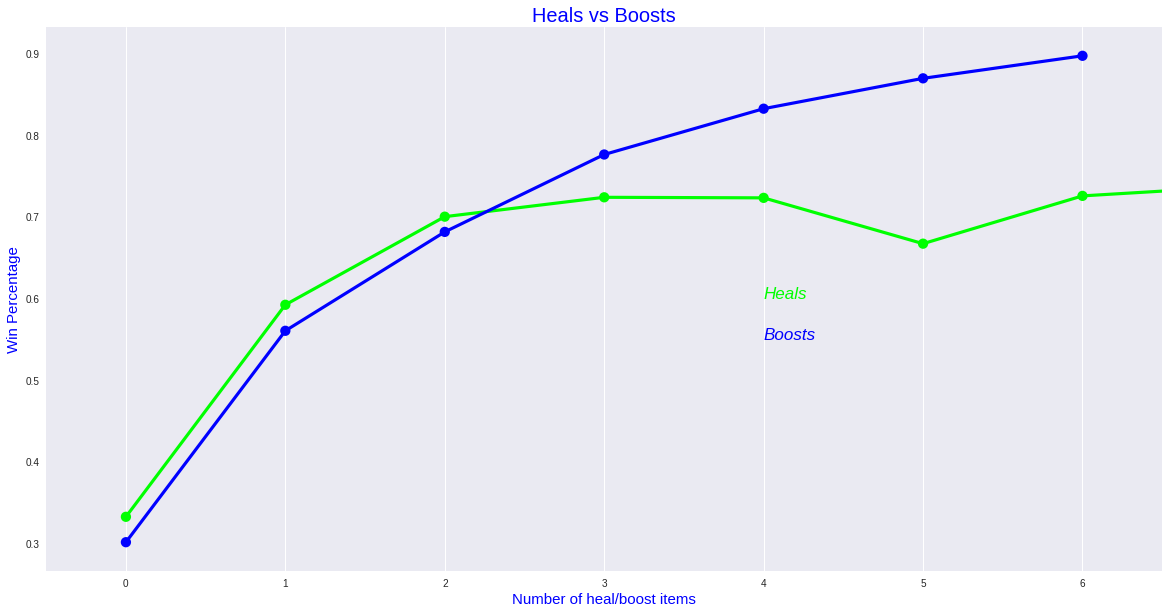

In [ ]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

In [ ]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="lime")
plt.show()

In [ ]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

In [ ]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

There are 709111 (15.00%) solo games, 3295326 (74.00%) duo games and 442529 (9.00%) squad games.


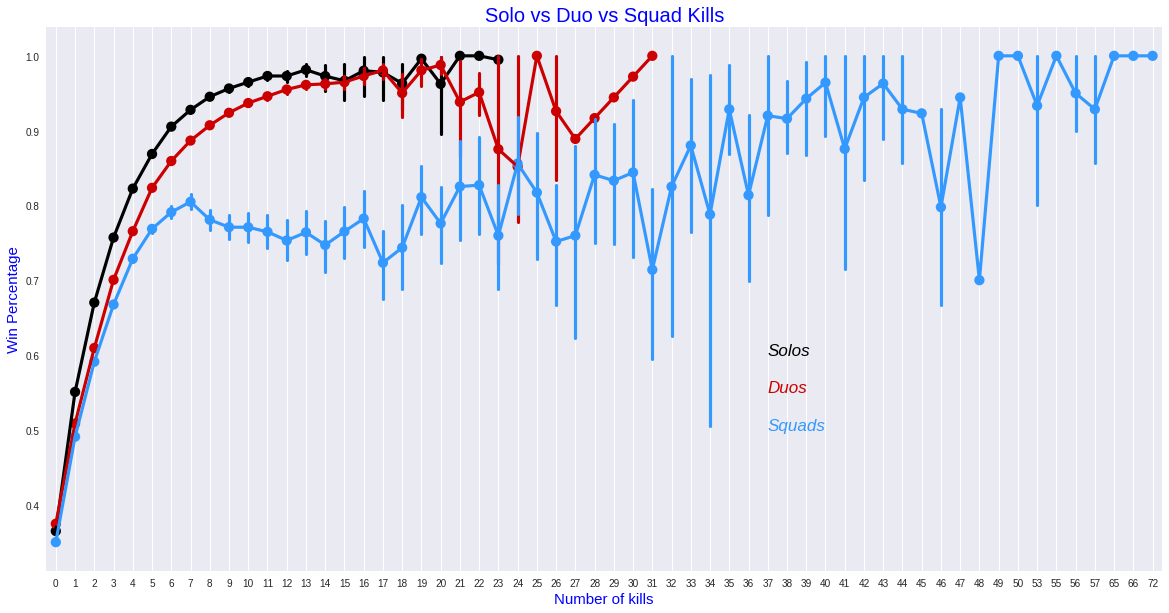

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

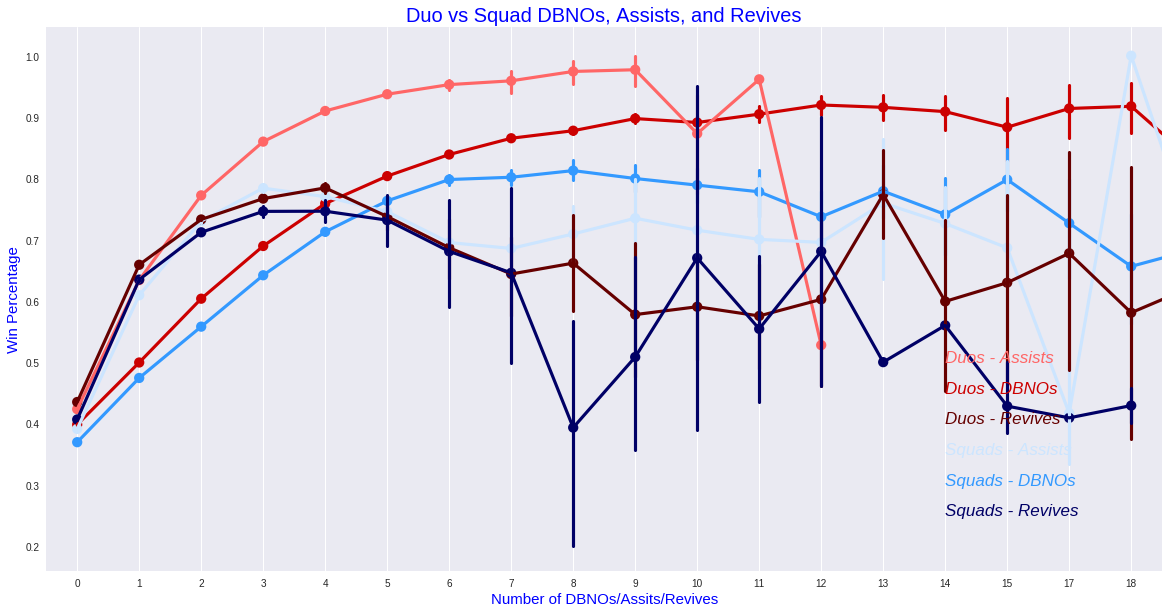

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

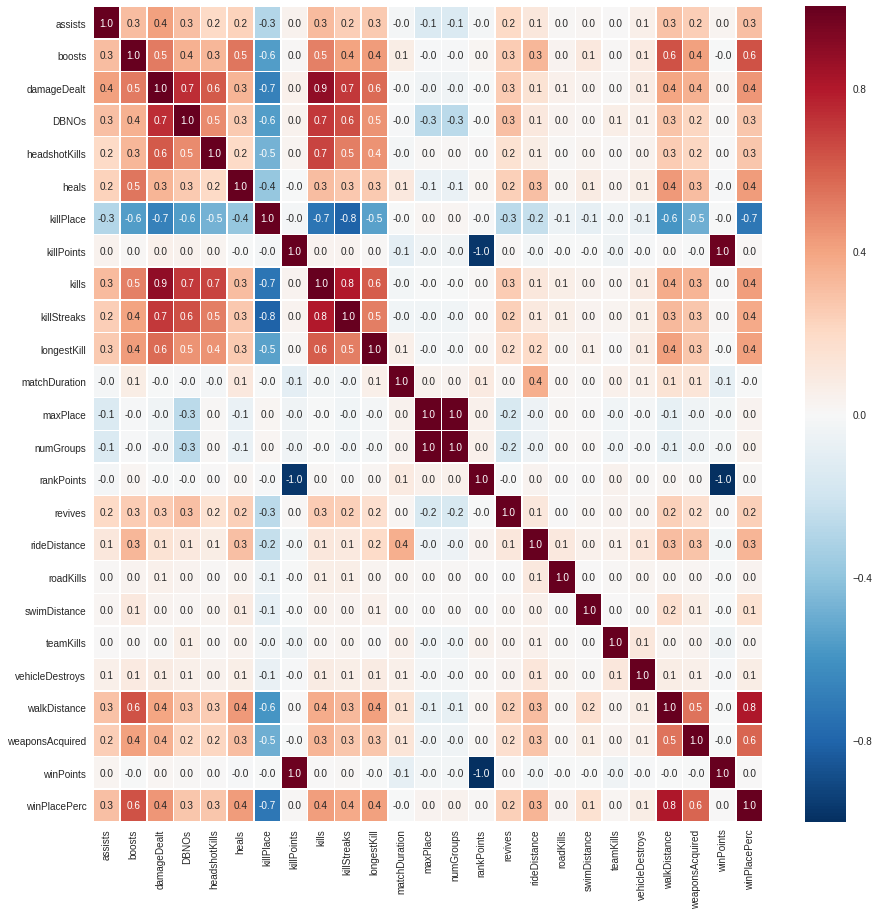

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

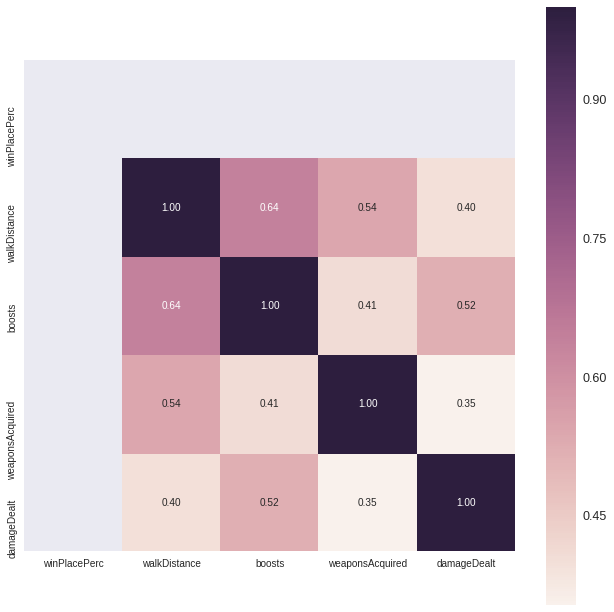

In [ ]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(train[cols], size = 2.5)
plt.show()

In [ ]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

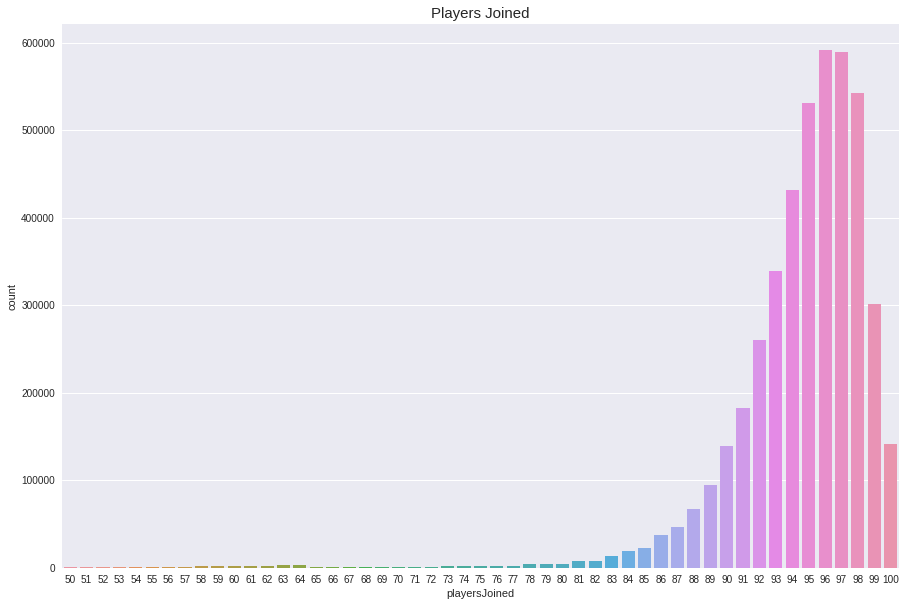

In [ ]:
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

In [ ]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][5:8]

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
5,95,1,1.05,100.000,105.00000
6,97,0,0.00,0.000,0.00000
7,96,0,0.00,8.538,8.87952


In [ ]:
train['healsAndBoosts'] = train['heals']+train['boosts']
train['totalDistance'] = train['walkDistance']+train['rideDistance']+train['swimDistance']

In [ ]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['walkDistance']+1) #The +1 is to avoid infinity.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

,walkDistance,boosts,boostsPerWalkDistance,heals,healsPerWalkDistance,healsAndBoosts,healsAndBoostsPerWalkDistance
40,327.30,1,0.003046,1,0.003046,2,0.006092
41,128.80,0,0.000000,0,0.000000,0,0.000000
42,52.52,0,0.000000,0,0.000000,0,0.000000
43,534.10,1,0.001869,0,0.000000,1,0.001869
44,2576.00,4,0.001552,6,0.002328,10,0.003880


In [ ]:
train['killsPerWalkDistance'] = train['kills']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,0.0,29.0,0.7500
3083358,30,0.0,0.0,30.0,0.7500
422093,30,0.0,0.0,30.0,1.0000
2394021,31,0.0,0.0,31.0,0.5385
3057746,31,0.0,0.0,31.0,0.7500
2998470,35,0.0,0.0,35.0,1.0000
1158891,36,0.0,0.0,36.0,0.5833
3062788,36,0.0,0.0,36.0,0.8667
1068513,38,0.0,0.0,38.0,0.8333
1702541,43,0.0,0.0,43.0,1.0000


In [ ]:
train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,96,0.00,0.0000,0,244.8000,0.0,0.0,0.0,0.000000,2
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,91,0.00,99.7023,0,1445.0445,0.0,0.0,0.0,0.000000,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,98,0.00,69.3600,0,161.8000,0.0,0.0,0.0,0.000000,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,91,0.00,35.8610,0,202.7000,0.0,0.0,0.0,0.000000,2
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,97,1.03,103.0000,0,49.7500,0.0,0.0,0.0,0.019704,1


In [ ]:

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]

    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

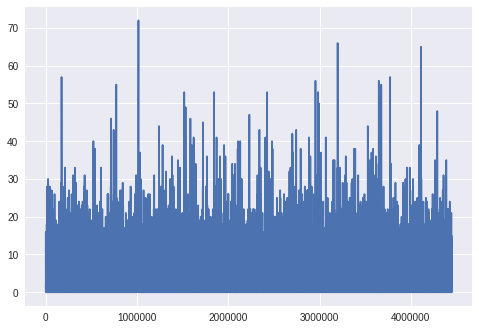

list index out of range


In [ ]:
data = pd.read_csv('gdrive/My Drive/train_V2.csv')[::-1]
data = data.ix[:, 'killsNorm'],['playersJoined'], ['winPlacePerc'],['groupId'].tolist()

# Uncomment below to use price change time series
# data = data.ix[:, 'Adj Close'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1]

    except Exception as e:
        print e
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train,
          epochs = 10,
          batch_size = 128,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 4002237 samples, validate on 444694 samples
Epoch 1/10
4002237/4002237 [==============================] - 98s 24us/step - loss: 0.8562 - acc: 0.6884 - val_loss: 0.5863 - val_acc: 0.6906

Epoch 00001: val_loss improved from inf to 0.58631, saving model to test.hdf5
Epoch 2/10
4002237/4002237 [==============================] - 98s 24us/step - loss: 0.5917 - acc: 0.6901 - val_loss: 0.5850 - val_acc: 0.6910

Epoch 00002: val_loss improved from 0.58631 to 0.58502, saving model to test.hdf5
Epoch 3/10
4002237/4002237 [==============================] - 97s 24us/step - loss: 0.5915 - acc: 0.6910 - val_loss: 0.5871 - val_acc: 0.6910

Epoch 00003: val_loss did not improve from 0.58502
Epoch 4/10
4002237/4002237 [==============================] - 96s 24us/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.5844 - val_acc: 0.6910

Epoch 00004: val_loss improved from 0.58502 to 0.58441, saving model to test.hdf5
Epoch 5/10
4002237/4002237 [==============================] - 97s 24us/step - loss

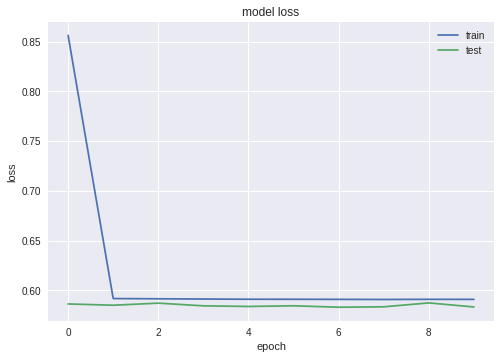

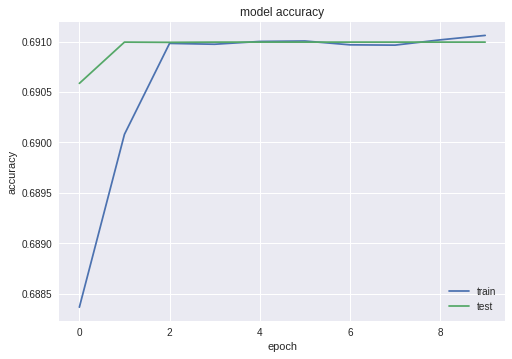

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

[[0.         0.44719003]
 [0.         1.        ]]


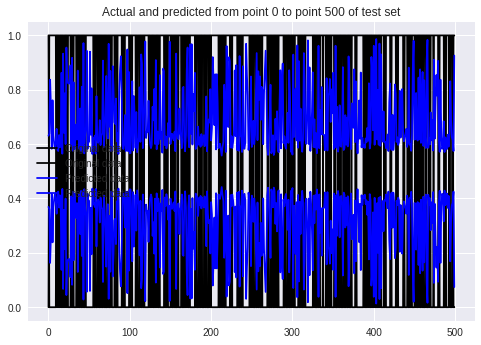

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print C / C.astype(np.float).sum(axis=1)

FROM = 0
TO = FROM + 500

original = Y_test[FROM:TO]
predicted = pred[FROM:TO]

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()